**ANALYSIS QUESTIONS**

1. Discover relationship between Total Complexity Points (as of May 2021) and subsequent production, outflow, and net. Nine months is probably preferred, but explore whether there are differences between 3 and 6 months.

2. Same as above, but for each individual Complexity input   (also, including the data on "Other Data" tab as separate variables).

3. Create simple model that tries to predict which clients will contribute over $1,000,000 in production in 9 months based on Complexity data only. Is there a "formula" for complexity that indicates that the client WILL, WON'T ever contribute significant production?

4. Explore link between Complexity Points and # of Meetings, Zooms, calls in subsequent 9 months.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from IPython.display import display
import warnings

In [2]:
# Set view options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

In [3]:
# Read in excel spreadsheets
complexity_columns = {
    'rel_id': 'RelID',
    'ComplexityRuleID': 'RuleID',
    'ComplexityRuleType': 'RuleType',
    'Name': 'Description'
}
complexity = pd.read_excel('../data/RohitCapstoneDataApr2022.xlsx', sheet_name = 'Complexity Data') \
    .rename(columns = complexity_columns)

prod_outflow_columns = {
    'rel_id': 'RelID', 
    'CurrentRelValue': 'CurrentValue',
    'Beginning Rel Value': 'BeginningValue',
    'ThreeMonthProd': '3MonthProd',
    'SixMonthProd': '6MonthProd',
    'NineMonthProd': '9MonthProd',
    'ThreeMonthOutflow': '3MonthOutflow',
    'SixMonthOutflow': '6MonthOutflow',
    'NineMonthOutflow': '9MonthOutflow'
}
prod_outflow = pd.read_excel('../data/RohitCapstoneDataApr2022.xlsx', sheet_name = 'Prod-Outflow Data', skiprows = 1) \
    .rename(columns = prod_outflow_columns)[prod_outflow_columns.values()]

other = pd.read_excel('../data/RohitCapstoneDataApr2022.xlsx', sheet_name = 'Other Data as of 202105') \
    .drop(columns = 'AsOf')

meetings = pd.read_excel('../data/RohitCapstoneDataApr2022.xlsx', sheet_name = 'Subsequent Mtgs', converters = {'AsOf': str})
date_filter = ['202106', '202107', '202108', '202109', '202110', '202111', '202112', '202201', '202202', '202203', '202204']
meetings = meetings.loc[meetings['AsOf'].isin(date_filter)]
meetings['Year'] = meetings['AsOf'].str[0:4]
meetings['Month'] = meetings['AsOf'].str[4:6]
meetings['Interactions'] = meetings['Call'] + meetings['Meeting'] + meetings['Zoom']

In [4]:
# Filter accounts with BeginningValue less than $500,000
prod_outflow = prod_outflow[prod_outflow['BeginningValue'] >= 500000]

# Calculate net, net percentage, and percentage change variables
prod_outflow['3MonthNet'] = prod_outflow['3MonthProd'] + prod_outflow['3MonthOutflow']
prod_outflow['6MonthNet'] = prod_outflow['6MonthProd'] + prod_outflow['6MonthOutflow']
prod_outflow['9MonthNet'] = prod_outflow['9MonthProd'] + prod_outflow['9MonthOutflow']

prod_outflow['3MonthNetPct'] = prod_outflow['3MonthNet'] / prod_outflow['BeginningValue'] * 100
prod_outflow['6MonthNetPct'] = prod_outflow['6MonthNet'] / prod_outflow['BeginningValue'] * 100
prod_outflow['9MonthNetPct'] = prod_outflow['9MonthNet'] / prod_outflow['BeginningValue'] * 100

In [5]:
# Sum up complexity points per RelID
complexity_pts = complexity.groupby('RelID', as_index = False)['# Pts'].sum()

# Sum up client interactions per RelID
interactions = meetings.loc[meetings['CategoryName'] == 'Client Review'].groupby(['RelID'], as_index = False)['Interactions'].sum()

# Merge complexity_pts, prod_outflow, other, and interactions data
pts_prod_outflow = complexity_pts.merge(prod_outflow, on = 'RelID').set_index('RelID')
pts_prod_outflow_other = pts_prod_outflow.merge(other, on = 'RelID').set_index('RelID')
pts_prod_outflow_other_interactions = pts_prod_outflow_other.merge(interactions, how = 'left', on = 'RelID').set_index('RelID').fillna(0)

In [6]:
# Sum up complexity rule dummy variables per RelID
complexity_rules = pd.get_dummies(complexity.set_index('RelID')['RuleID'].astype(str)).groupby('RelID').sum().reset_index()

# Create ordinal complexity rule variables
complexity_rules['2-3'] = complexity_rules['2'] * 1 + complexity_rules['3'] * 2
complexity_rules['4-5'] = complexity_rules['4'] * 1 + complexity_rules['5'] * 2
complexity_rules['6-7'] = complexity_rules['6'] * 1 + complexity_rules['7'] * 2
complexity_rules['8-9'] = complexity_rules['8'] * 1 + complexity_rules['9'] * 2
complexity_rules['10-13'] = complexity_rules['10'] * 1 + complexity_rules['11'] * 2 + complexity_rules['12'] * 3 + complexity_rules['13'] * 4
complexity_rules['14-16'] = complexity_rules['14'] * 1 + complexity_rules['15'] * 2 + complexity_rules['16'] * 3
complexity_rules['41-43'] = complexity_rules['41'] * 1 + complexity_rules['42'] * 2 + complexity_rules['43'] * 3
complexity_rules['49-51'] = complexity_rules['49'] * 1 + complexity_rules['50'] * 2 + complexity_rules['51'] * 3
complexity_rules['52-53'] = complexity_rules['52'] * 1 + complexity_rules['53'] * 2
complexity_rules['65'] = 1 - complexity_rules[['4', '5', '60']].sum(axis = 1)

# Merge complexity_rules, prod_outflow, other, and interactions data
rules_prod_outflow = complexity_rules.merge(prod_outflow, on = 'RelID').set_index('RelID')
rules_prod_outflow_other = rules_prod_outflow.merge(other, on = 'RelID').set_index('RelID')
rules_prod_outflow_other_interactions = rules_prod_outflow_other.merge(interactions, how = 'left', on = 'RelID').set_index('RelID').fillna(0)

In [7]:
# Define feature sets
collapsed_rules = [
    '1', '2-3', '4-5', '6-7', '8-9', '10-13', '14-16', '17', '18', '19',
    '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', 
    '32', '33', '37', '38', '39', '40', '41-43', '45', '49-51', '52-53',
    '54', '55', '56', '57', '58', '62', '63', '65'
]

In [8]:
# Show complexity rules
complexity_table = complexity[['Description', 'RuleID', 'RuleType', '# Pts']].sort_values('RuleID').drop_duplicates().reset_index(drop = True)
complexity_table = complexity_table.merge(complexity.merge(pts_prod_outflow_other_interactions[[]], on = 'RelID').value_counts('RuleID').to_frame('# RelIDs'), on = 'RuleID')
display(complexity_table)

,Description,RuleID,RuleType,# Pts,# RelIDs
0,One or more owners is a QP,1,Rel structure,1,6238
1,One or more owners is 'Key',2,Rel structure,1,2955
2,One or more owners is 'Super Key',3,Rel structure,2,3053
3,One or more owners is a Validator,4,Rel structure,1,3918
4,One or more owners is a Soloist,5,Rel structure,2,1306
5,"Relationship has 1-2 investing entities other than personal, joint, or IRA",6,Rel structure,1,13781
6,"Relationship has 3+ investing entities other than personal, joint, or IRA",7,Rel structure,2,1295
7,Relationship has 3-5 Tax IDs,8,Rel structure,1,4419
8,Relationship has 6+ Tax IDs,9,Rel structure,2,787
9,Relationship has one Alt. or FE,10,Products and services,1,2817


In [9]:
# Logistic LASSO pipeline
lr_l1_pipeline = Pipeline(
    steps = [
        ('scaler', StandardScaler()),
        ('vt', VarianceThreshold()),
        ('logistic', LogisticRegression(penalty = 'l1', class_weight = 'balanced', solver = 'saga', max_iter = 1000, random_state = 321))
    ]
)

In [10]:
# Perform train/test split (collapsed complexity rules, indeterminate set filter)
X = rules_prod_outflow_other_interactions
y = (rules_prod_outflow_other_interactions['9MonthProd'] >= 1000000).astype(int)
X_train_collapsed_rules_indeterminate_set, X_test_collapsed_rules_indeterminate_set, y_train_collapsed_rules_indeterminate_set, y_test_collapsed_rules_indeterminate_set = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 321)

# Filter out indeterminate set
indeterminate_filter = X_train_collapsed_rules_indeterminate_set.loc[~X_train_collapsed_rules_indeterminate_set['9MonthProd'].between(250000, 1000000)].index
X_train_collapsed_rules_indeterminate_set, y_train_collapsed_rules_indeterminate_set = X_train_collapsed_rules_indeterminate_set.loc[indeterminate_filter], y_train_collapsed_rules_indeterminate_set.loc[indeterminate_filter]

# Run grid search using logistic LASSO pipeline
grid_search_collapsed_rules_indeterminate_set = GridSearchCV(estimator = lr_l1_pipeline, param_grid = {'logistic__C': [0.1, 0.05, 0.01]}, scoring = 'f1', cv = 3)
grid_search_collapsed_rules_indeterminate_set.fit(X_train_collapsed_rules_indeterminate_set[collapsed_rules], y_train_collapsed_rules_indeterminate_set)
grid_search_collapsed_rules_indeterminate_set.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('vt', VarianceThreshold()),
                ('logistic',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=321, solver='saga'))])

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      6577
           1       0.14      0.71      0.24       411

    accuracy                           0.74      6988
   macro avg       0.56      0.72      0.54      6988
weighted avg       0.93      0.74      0.81      6988



,,Avg Prod,Median Prod,$1M+ Prod,$1M+ Prod %,Est. P(1),P(1),Est. Odds,Odds,Lift
Interval,Ventile,,,,,,,,,
1,"(0.82, 1.0]",1768351.17,389207.30,112,27.25,0.90,0.32,9.02,0.47,5.44
2,"(0.72, 0.82]",1258367.98,86652.15,54,40.39,0.76,0.15,3.25,0.18,4.04
3,"(0.64, 0.72]",836637.40,46681.74,49,52.31,0.68,0.14,2.11,0.16,3.48
4,"(0.59, 0.64]",234506.37,30326.92,26,58.64,0.61,0.07,1.57,0.08,2.93
5,"(0.53, 0.59]",510564.46,28136.27,36,67.40,0.56,0.10,1.26,0.12,2.70
6,"(0.49, 0.53]",346666.05,12165.10,17,71.53,0.51,0.05,1.04,0.05,2.38
7,"(0.44, 0.49]",217375.32,489.37,14,74.94,0.46,0.04,0.87,0.04,2.14
8,"(0.41, 0.44]",130462.47,452.77,14,78.35,0.43,0.04,0.75,0.04,1.96
9,"(0.38, 0.41]",124978.35,256.45,12,81.27,0.39,0.03,0.65,0.04,1.81


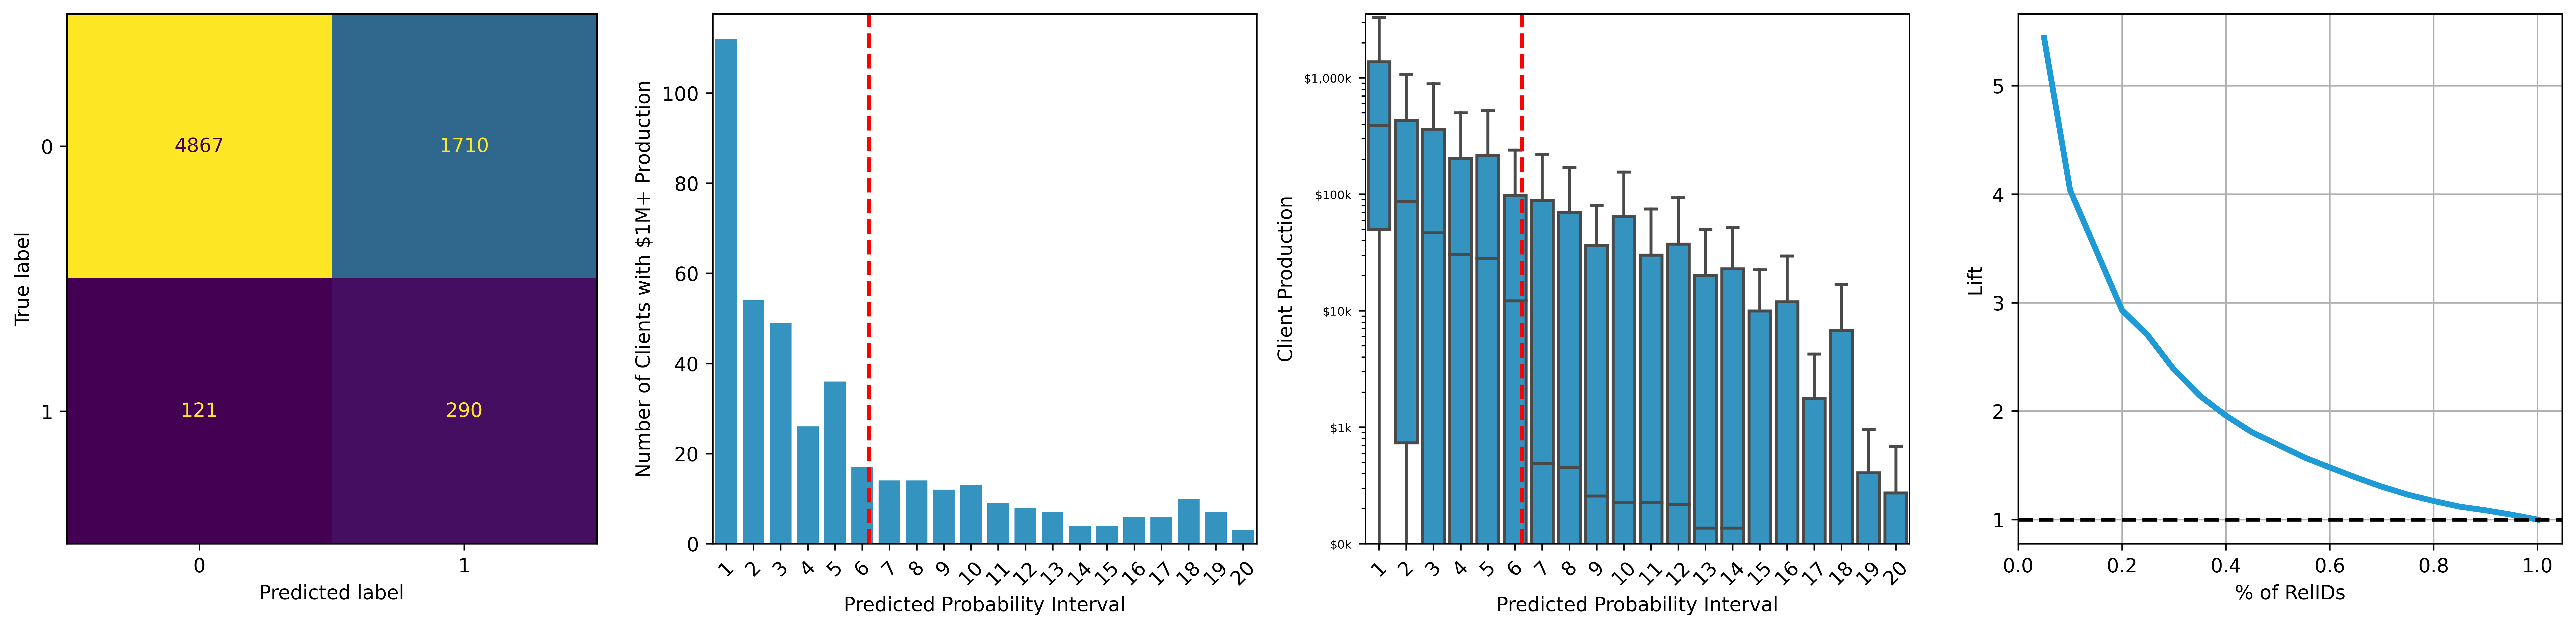

,Coefficient,Description
Variable,,
65,0.33,"One or more owners is NOT a Delagator, Validator, or Soloist"
20,0.26,Relationship contains individually managed bonds
2-3,0.26,One or more owners is [Key] / [Super Key]
27,0.19,Relationship has 1+ accounts invested in institutional products
21,-0.18,Relationship contains 3+ individually managed equity services
6-7,0.16,"Relationship has [1-2] / [3+] investing entities other than personal, joint, or IRA"
49-51,0.14,Relationship has [10-15] / [16-20] / [21+] invested accounts
57,0.13,"Relationship has a resource request with one of the following resources: Barnard, Eisenman, Chaloff, Kirr, Bates, Turner"
10-13,0.13,Relationship has [1] / [2-5] / [5-7] / [8+] Alt. or FE


In [11]:
# Output logistic LASSO model results (collapsed complexity rules, indeterminate set filter)
print(classification_report(y_test_collapsed_rules_indeterminate_set, grid_search_collapsed_rules_indeterminate_set.predict(X_test_collapsed_rules_indeterminate_set[collapsed_rules]), zero_division = 0))

# Create summary_df, boxplot_df, and liftcurve_df
summary_df = pd.DataFrame({
    'Avg Prod': X_test_collapsed_rules_indeterminate_set['9MonthProd'],
    'Median Prod': X_test_collapsed_rules_indeterminate_set['9MonthProd'],
    '$1M+ Prod': y_test_collapsed_rules_indeterminate_set,
    '$1M+ Prod %': y_test_collapsed_rules_indeterminate_set,
    'Est. P(1)': grid_search_collapsed_rules_indeterminate_set.best_estimator_.predict_proba(X_test_collapsed_rules_indeterminate_set[collapsed_rules])[:, 1],
    'P(1)': 1,
    'Est. Odds': None,
    'Odds': None,
    'Lift': 1
})

summary_df['Interval'] = pd.qcut(summary_df['Est. P(1)'], q = 20, labels = False, precision = 0, duplicates = 'drop')
summary_df['Interval'] = max(summary_df['Interval']) + 1 - summary_df['Interval']
summary_df['Ventile'] = pd.qcut(summary_df['Est. P(1)'], q = 20, precision = 0)

boxplot_df = summary_df.rename(columns = {'Median Prod':'Production'}).copy()
boxplot_df['Production'] = boxplot_df['Production'] / 1000

agg_dict = {
    'Avg Prod': 'mean',
    'Median Prod': 'median',
    '$1M+ Prod': 'sum',
    '$1M+ Prod %': 'sum',
    'Est. P(1)': 'mean',
    'P(1)': 'sum',
    'Est. Odds': 'sum',
    'Odds': 'sum',
    'Lift': 'sum'
}

summary_df = summary_df.groupby(['Interval', 'Ventile']).agg(agg_dict).dropna()
summary_df['$1M+ Prod %'] = summary_df['$1M+ Prod'].cumsum() / summary_df['$1M+ Prod'].sum() * 100
summary_df['P(1)'] = summary_df['$1M+ Prod'] / summary_df['P(1)']
summary_df['Est. Odds'] = summary_df['Est. P(1)'] / (1 - summary_df['Est. P(1)'])
summary_df['Odds'] = summary_df['P(1)'] / (1 - summary_df['P(1)'])
summary_df['Lift'] = (summary_df['$1M+ Prod'].cumsum() / summary_df['Lift'].cumsum()) / (sum(summary_df['$1M+ Prod']) / sum(summary_df['Lift']))

liftcurve_df = summary_df.copy()
liftcurve_df['% of RelIDs'] = summary_df.index.get_level_values('Interval') / max(summary_df.index.get_level_values('Interval'))

barplot_df = summary_df.copy()
barplot_df['Interval'] = summary_df.index.get_level_values('Interval')

display(summary_df)

# Create plots
fig, axs = plt.subplots(1, 4, figsize = (23, 5), dpi = 600)
ConfusionMatrixDisplay.from_estimator(
    estimator = grid_search_collapsed_rules_indeterminate_set.best_estimator_,
    X = X_test_collapsed_rules_indeterminate_set[collapsed_rules], 
    y = y_test_collapsed_rules_indeterminate_set,
    colorbar = False,
    ax = axs[0]
)
sns.barplot(x = 'Interval', y = '$1M+ Prod', data = barplot_df, color = '#1E9BD7', ax = axs[1])
axs[1].tick_params(axis = 'x', labelrotation = 45)
axs[1].axvline(x = 5.25, color = 'red', linewidth = 2, linestyle='--')
axs[1].set_xlabel('Predicted Probability Interval')
axs[1].set_ylabel('Number of Clients with $1M+ Production')
sns.boxplot(x = 'Interval', y = 'Production', data = boxplot_df, color = '#1E9BD7', showfliers = False, ax = axs[2])
axs[2].set_ylim(bottom = 0.1)
axs[2].set(yscale = 'log')
axs[2].tick_params(axis = 'x', labelrotation = 45)
axs[2].tick_params(axis = 'y', labelsize = 6)
axs[2].axvline(x = 5.25, color = 'red', linewidth = 2, linestyle='--')
axs[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}k'))
axs[2].set_xlabel('Predicted Probability Interval')
axs[2].set_ylabel('Client Production')
sns.lineplot(x = '% of RelIDs', y = 'Lift', data = liftcurve_df, color = '#1E9BD7', linewidth = 3, ax = axs[3])
axs[3].xaxis.set_ticks(np.arange(0, 6) / 5)
axs[3].axhline(y = 1, color = 'black', linewidth = 2, linestyle='--')
axs[3].grid()
plt.show()

# Create coefficients_df
coefficients_df = pd.DataFrame({
    'Coefficient': [grid_search_collapsed_rules_indeterminate_set.best_estimator_['logistic'].intercept_[0]] + list(grid_search_collapsed_rules_indeterminate_set.best_estimator_['logistic'].coef_[0]),
    'Variable': ['intercept'] + list(np.array(X_train_collapsed_rules_indeterminate_set[collapsed_rules].columns)[grid_search_collapsed_rules_indeterminate_set.best_estimator_['vt'].get_support()])
})[1:].merge(complexity_table[['Description', 'RuleID']].astype(str).set_index('RuleID'), how = 'left', left_on = 'Variable', right_on = 'RuleID')
coefficients_df.loc[coefficients_df['Variable'] == '2-3', 'Description'] = 'One or more owners is [Key] / [Super Key]'
coefficients_df.loc[coefficients_df['Variable'] == '4-5', 'Description'] = 'One or more owners is a [Validator] / [Soloist]'
coefficients_df.loc[coefficients_df['Variable'] == '6-7', 'Description'] = 'Relationship has [1-2] / [3+] investing entities other than personal, joint, or IRA'
coefficients_df.loc[coefficients_df['Variable'] == '8-9', 'Description'] = 'Relationship has [3-5] / [6+] Tax IDs'
coefficients_df.loc[coefficients_df['Variable'] == '10-13', 'Description'] = 'Relationship has [1] / [2-5] / [5-7] / [8+] Alt. or FE'
coefficients_df.loc[coefficients_df['Variable'] == '14-16', 'Description'] = 'One Alt. or FE subscription/commitment of [$1-2M] / [$2-5M] / [$5M+]'
coefficients_df.loc[coefficients_df['Variable'] == '41-43', 'Description'] = 'Relationship has had an approved WFA analyze [$5-10M] / [$10-20M] / [$20M+]'
coefficients_df.loc[coefficients_df['Variable'] == '49-51', 'Description'] = 'Relationship has [10-15] / [16-20] / [21+] invested accounts'
coefficients_df.loc[coefficients_df['Variable'] == '52-53', 'Description'] = 'Fee relationship has [3-5] / [5+] sales relationships linked'
coefficients_df.loc[coefficients_df['Variable'] == '65', 'Description'] = 'One or more owners is NOT a Delagator, Validator, or Soloist'
coefficients_df = coefficients_df.set_index('Variable')
display(coefficients_df[coefficients_df['Coefficient'] != 0].sort_values('Coefficient', ascending = False, key = abs).fillna(''))

In [12]:
# Calculate cluster activations
cluster_1 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['60', '64']].sum(axis = 1) == 2]
cluster_2 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['60', '10', '11', '12', '13']].sum(axis = 1) == 2]
cluster_3 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['4', '64']].sum(axis = 1) == 2]
cluster_4 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['4', '10', '11', '12', '13']].sum(axis = 1) == 2]
cluster_5 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['5', '64']].sum(axis = 1) == 2]
cluster_6 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['5', '10', '11', '12', '13']].sum(axis = 1) == 2]
cluster_7 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['65', '64']].sum(axis = 1) == 2]
cluster_8 = rules_prod_outflow_other_interactions[rules_prod_outflow_other_interactions[['65', '10', '11', '12', '13']].sum(axis = 1) == 2]

coefficients_df['Del_0_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_1[collapsed_rules].sum() / len(cluster_1[collapsed_rules])))
coefficients_df['Del_1+_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_2[collapsed_rules].sum() / len(cluster_2[collapsed_rules])))
coefficients_df['Val_0_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_3[collapsed_rules].sum() / len(cluster_3[collapsed_rules])))
coefficients_df['Val_1+_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_4[collapsed_rules].sum() / len(cluster_4[collapsed_rules])))
coefficients_df['Sol_0_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_5[collapsed_rules].sum() / len(cluster_5[collapsed_rules])))
coefficients_df['Sol_1+_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_6[collapsed_rules].sum() / len(cluster_6[collapsed_rules])))
coefficients_df['Other_0_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_7[collapsed_rules].sum() / len(cluster_7[collapsed_rules])))
coefficients_df['Other_1+_Alt'] = abs(coefficients_df['Coefficient'] * (cluster_8[collapsed_rules].sum() / len(cluster_8[collapsed_rules])))
display(coefficients_df[coefficients_df['Coefficient'] != 0].sort_values('Coefficient', ascending = False, key = abs).fillna(''))

,Coefficient,Description,Del_0_Alt,Del_1+_Alt,Val_0_Alt,Val_1+_Alt,Sol_0_Alt,Sol_1+_Alt,Other_0_Alt,Other_1+_Alt
Variable,,,,,,,,,,
65,0.33,"One or more owners is NOT a Delagator, Validator, or Soloist",0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.33
20,0.26,Relationship contains individually managed bonds,0.02,0.07,0.04,0.10,0.08,0.08,0.03,0.06
2-3,0.26,One or more owners is [Key] / [Super Key],0.07,0.18,0.13,0.25,0.13,0.26,0.00,0.00
27,0.19,Relationship has 1+ accounts invested in institutional products,0.10,0.13,0.12,0.15,0.12,0.15,0.06,0.09
21,-0.18,Relationship contains 3+ individually managed equity services,0.17,0.17,0.16,0.17,0.14,0.14,0.13,0.12
6-7,0.16,"Relationship has [1-2] / [3+] investing entities other than personal, joint, or IRA",0.10,0.12,0.12,0.14,0.12,0.13,0.09,0.09
49-51,0.14,Relationship has [10-15] / [16-20] / [21+] invested accounts,0.04,0.13,0.04,0.15,0.02,0.09,0.02,0.07
57,0.13,"Relationship has a resource request with one of the following resources: Barnard, Eisenman, Chaloff, Kirr, Bates, Turner",0.00,0.01,0.01,0.02,0.02,0.02,0.00,0.02
10-13,0.13,Relationship has [1] / [2-5] / [5-7] / [8+] Alt. or FE,0.00,0.23,0.00,0.27,0.00,0.26,0.00,0.22


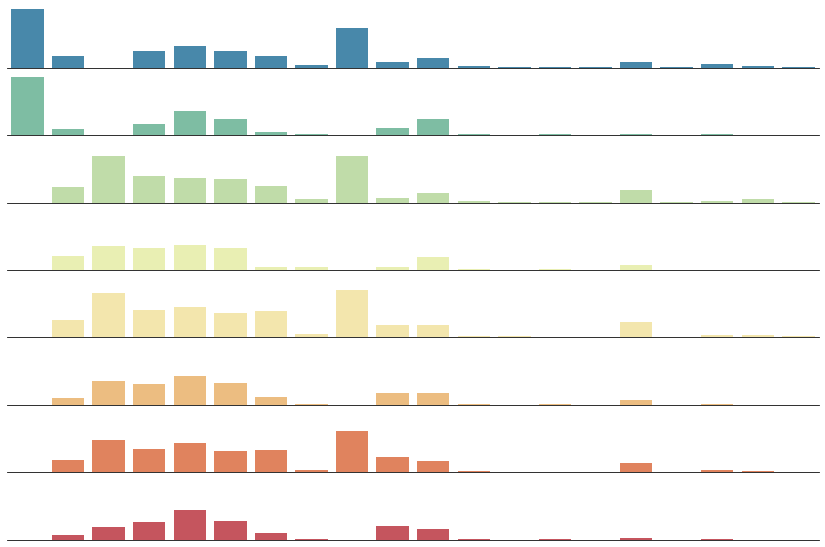

In [13]:
# Create activations figure
activations = pd.melt(coefficients_df.sort_values('Coefficient', ascending = False, key = abs).head(20), id_vars = ['Coefficient', 'Description'])

g = sns.FacetGrid(
    data = activations,
    row = 'variable', 
    row_order = ['Other_1+_Alt', 'Other_0_Alt', 'Sol_1+_Alt', 'Sol_0_Alt', 'Val_1+_Alt', 'Val_0_Alt', 'Del_1+_Alt', 'Del_0_Alt'], 
    hue = 'variable', 
    palette = 'Spectral', 
    margin_titles = True, 
    height = 1, 
    aspect = 12
)
g.map(sns.barplot, 'Description', 'value', ci = None)
g.set_titles(row_template = '')

for axes in g.axes.flat:
    axes.tick_params(bottom = False)
    axes.set_ylabel('')
    axes.get_yaxis().set_visible(False)
    axes.get_xaxis().set_visible(False)
    axes.spines['left'].set_visible(False)
plt.subplots_adjust(hspace = 0.1)
plt.savefig('../images/activations.png', bbox_inches = 'tight', dpi = 600)
plt.show()